In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

In [2]:
import dataloader
import utils
import cnnlstm
from utils import mae, rmse

import sys
import time
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import gc

from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, RepeatVector
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
#importing required libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Flatten, TimeDistributed

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

# Model Data range
date = datetime.datetime(2021,3,12)
# Total entry count
count = 1200
# Training entry count
training_count = 1000
history_size = 30

%load_ext autoreload
%autoreload 2

# IBIO

In [3]:
path = "../032721Comparison/Data/IBIO2021.csv"
# Load data
train_x, train_y, test_x, test_y = utils.get_train_and_test_set(
    path, date, count, history_size, training_count
)

(1258, 7)
(1258, 7)
(1257, 7)
(1257, 7)
(1200, 7)
(970, 30, 1)
(200, 30, 1)


In [4]:
unit_params = range(30, 60, 5)
filter_params = [2, 4, 8, 16]
kernel_params = [2, 4, 8]
best_config, best_err = cnnlstm.cnnlstm_model_selection(train_x, train_y, unit_params, filter_params, kernel_params)
print(best_config, best_err)

2 2 30 mean val RMSE: 0.10365099018398712
2 2 35 mean val RMSE: 0.11269010763190376
2 2 40 mean val RMSE: 0.10412940119832956
2 2 45 mean val RMSE: 0.19472703215249432
2 2 50 mean val RMSE: 0.08269476103723664
2 2 55 mean val RMSE: 0.059093023283211775
2 4 30 mean val RMSE: 0.12456397590781643
2 4 35 mean val RMSE: 0.06633961907863387
2 4 40 mean val RMSE: 0.03456255947861939
2 4 45 mean val RMSE: 0.031640241730952465
2 4 50 mean val RMSE: 0.043472871386300675
2 4 55 mean val RMSE: 0.10032878346991625
2 8 30 mean val RMSE: 0.06747051679709563
2 8 35 mean val RMSE: 0.04140679629252323
2 8 40 mean val RMSE: 0.11980413214115822
2 8 45 mean val RMSE: 0.14754610502817564
2 8 50 mean val RMSE: 0.043716331857971746
2 8 55 mean val RMSE: 0.06574069191385992
4 2 30 mean val RMSE: 0.037675270128298646
4 2 35 mean val RMSE: 0.03022604624732884
4 2 40 mean val RMSE: 0.03017273213421549
4 2 45 mean val RMSE: 0.07337990762993088
4 2 50 mean val RMSE: 0.07603247770299229
4 2 55 mean val RMSE: 0.03161

In [5]:
model = None
gc.collect()

filter_size, kernel_size, unit_count = best_config

model = cnnlstm.cnnlstm_model(test_x, filter_size, kernel_size, unit_count)
model.fit(train_x, train_y, epochs=100, batch_size=32, verbose=1)
print(model.summary())
y_hat = model.predict(test_x).transpose()[0]

del model
gc.collect()

Epoch 1/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0468
Epoch 2/100
31/31 [==============================] - 0s 4ms/step - loss: 0.0038
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 4/100
31/31 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 9.3960e-04
Epoch 8/100
31/31 [==============================] - 0s 4ms/step - loss: 8.5136e-04
Epoch 9/100
31/31 [==============================] - 0s 4ms/step - loss: 8.2313e-04
Epoch 10/100
31/31 [==============================] - 0s 4ms/step - loss: 7.6247e-04
Epoch 11/100
31/31 [==============================] - 0s 4ms/step - loss: 7.3285e-04
Epoch 12/100
31/31 [==============================] - 0s 4ms/step - loss: 6.8308e-04
Epoch 13/100


31/31 [==============================] - 0s 4ms/step - loss: 4.2827e-04
Epoch 98/100
31/31 [==============================] - 0s 4ms/step - loss: 4.7923e-04
Epoch 99/100
31/31 [==============================] - 0s 4ms/step - loss: 4.4390e-04
Epoch 100/100
31/31 [==============================] - 0s 4ms/step - loss: 4.4578e-04
Model: "sequential_360"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_720 (Conv1D)          (None, 29, 8)             24        
_________________________________________________________________
conv1d_721 (Conv1D)          (None, 28, 8)             136       
_________________________________________________________________
max_pooling1d_360 (MaxPoolin (None, 14, 8)             0         
_________________________________________________________________
flatten_720 (Flatten)        (None, 112)               0         
______________________________________________________

20723

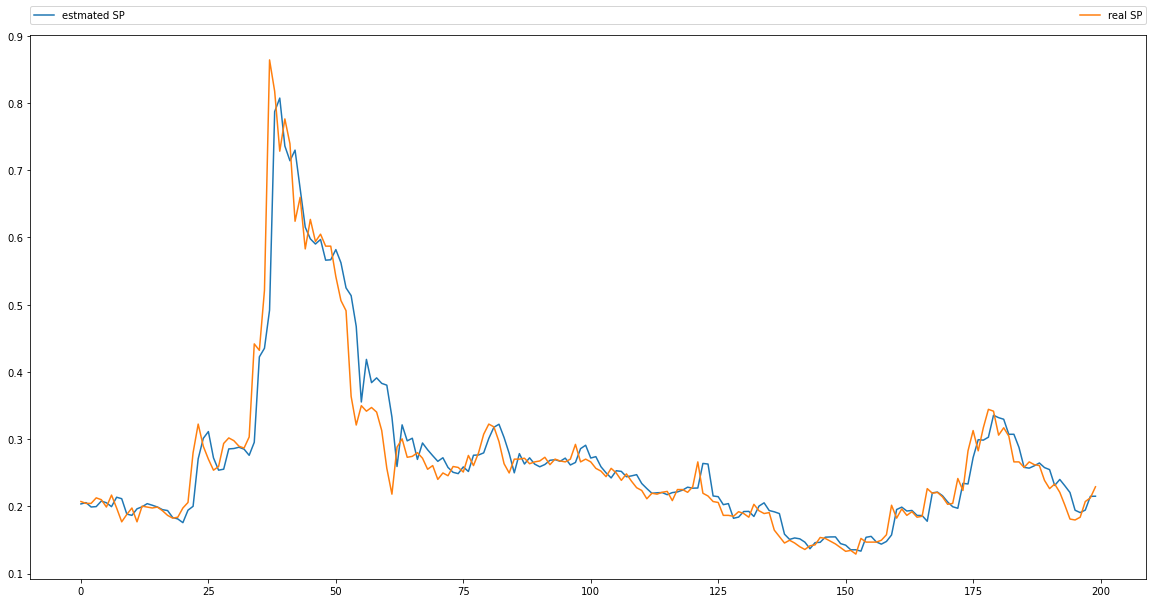

In [6]:
plt.plot(y_hat[:], label="estmated SP")
plt.plot(test_y[:], label="real SP")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

In [7]:
print("MAE:  ", mae(y_hat, test_y))
print("RMSE: ", rmse(y_hat, test_y))

MAE:   0.021546744017750637
RMSE:  0.041718622187069246
